## Tugas Akhir Microcredential Associate Data Scientist

### ITS-05 kelompok 3

#### Preface

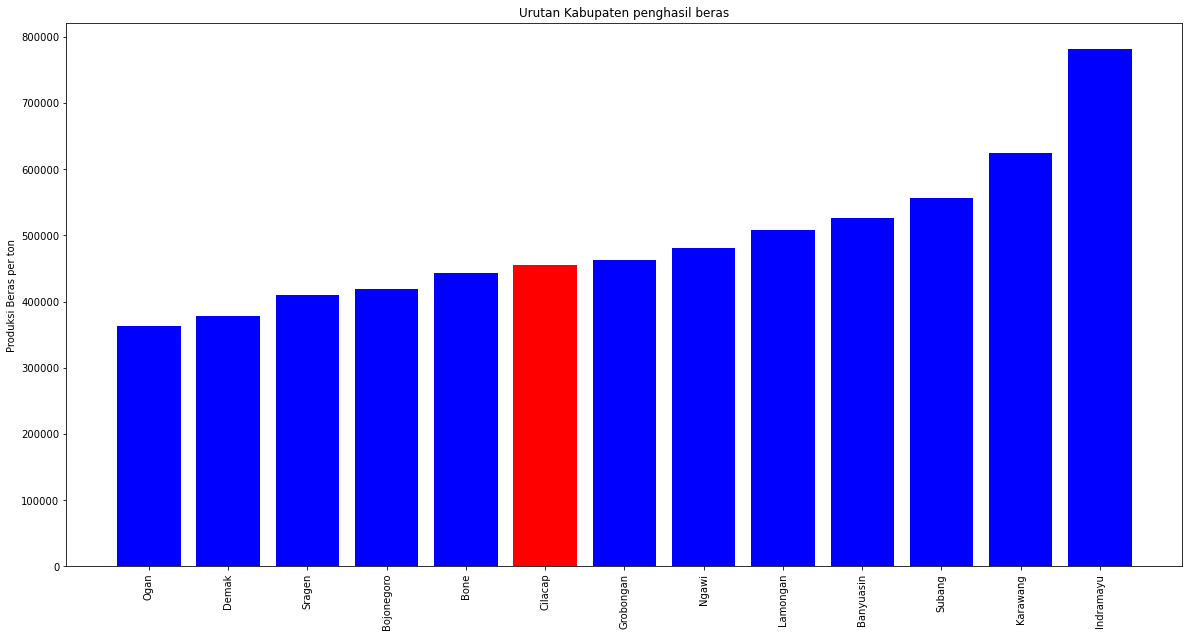

# 1. Import Necessary Library and Dataset

In [1]:
# Basic Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visulization
import missingno as mno
from sklearn.metrics import confusion_matrix

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Deep Learning
from keras.layers import Dense, Activation
from keras.models import Sequential

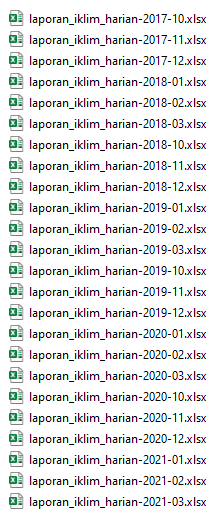

In [2]:
# import 3 periode of season
# 2018-10 ~ 2019-03
# 2019-10 ~ 2020-03
# 2020-10 ~ 2021-03

ignore_data = ["8888"] # temporary, kalau ada ide buat ngolah nilai "8888", command ini bisa dihilangkan

#df = pd.read_excel('dataset_iklim_cilacap_before_cleaning.xlsx', na_values = ignore_data)

# kalau emang perlu tambahan periode 2017-10 ~ 2018-03
# code dibawah bisa di un-comment
df = pd.read_excel('dataset_iklim_cilacap_before_cleaning_plus_plus.xlsx', na_values = ignore_data) # versi 4 periode

In [3]:
# Quick data check

print(f"DataFrame shape : {df.shape}\n")
print(f"DataFrame columns: \n{df.columns}\n")
print(f"Columns type: {df.dtypes}")

df.head(3)

DataFrame shape : (729, 11)

DataFrame columns: 
Index(['Tanggal', 'Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x',
       'ff_avg', 'ddd_car'],
      dtype='object')

Columns type: Tanggal     object
Tn         float64
Tx         float64
Tavg       float64
RH_avg     float64
RR         float64
ss         float64
ff_x       float64
ddd_x      float64
ff_avg     float64
ddd_car     object
dtype: object


,Tanggal,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car
0,01-10-2017,25.0,29.3,27.4,82.0,0.6,7.0,6.0,120.0,4.0,SE
1,02-10-2017,25.0,29.2,27.0,81.0,NaN,7.3,4.0,130.0,3.0,SE
2,03-10-2017,26.0,27.2,26.0,87.0,NaN,8.3,4.0,120.0,2.0,SE


In [4]:
# Quick data prep

# kita ingin mengolah dataset ini di domain timeseries
from datetime import datetime
df['datetime'] = [datetime.strptime(x,'%d-%m-%Y') for x in df['Tanggal']] # change string 'Tanngal' to timeseries format

# change datetime as index; 
df = df.set_index('datetime')
df.drop('Tanggal', axis=1, inplace=True)

# change 'ddd_car' to categorical
df['ddd_car'] = pd.Categorical(df.ddd_car)

# renaming columns
df.rename(columns={"RR": "curah_hujan", "Tavg": "temp_avg", "RH_avg": "humid_avg", 
                   "ss": "sun_expo", "ff_x": "wind_max", "ff_avg": "wind_avg", "Tn": "temp_min", 
                   "Tx": "temp_max", "ddd_car": "wind_dir", "ddd_x": "wind_dir_max"}, inplace=True)



# Menambahkan kolom 'Year', 'Month', 'Weekday' untuk mempermudah visualisasi dan statiscical need
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday

# change to categorical
df['Year'] = pd.Categorical(df.Year)
df['Month'] = pd.Categorical(df.Month)

In [5]:
# Dividing 1 dataset to 4 periode (just for easier visualization & statistical description)
# 2017-10 ~ 2018-03
# 2018-10 ~ 2019-03
# 2019-10 ~ 2020-03
# 2020-10 ~ 2021-03

df_periode1 = df.loc['2017-10-01':'2018-03-01']
df_periode2 = df.loc['2018-10-01':'2019-03-01']
df_periode3 = df.loc['2019-10-01':'2020-03-01']
df_periode4 = df.loc['2020-10-01':'2021-03-01']

In [6]:
df_periode1.head(3)

,temp_min,temp_max,temp_avg,humid_avg,curah_hujan,sun_expo,wind_max,wind_dir_max,wind_avg,wind_dir,Year,Month,Weekday
datetime,,,,,,,,,,,,,
2017-10-01,25.0,29.3,27.4,82.0,0.6,7.0,6.0,120.0,4.0,SE,2017,10,6
2017-10-02,25.0,29.2,27.0,81.0,NaN,7.3,4.0,130.0,3.0,SE,2017,10,0
2017-10-03,26.0,27.2,26.0,87.0,NaN,8.3,4.0,120.0,2.0,SE,2017,10,1


# 2. Exploratory Data Analysis

## 2.1 General Statistics

In [7]:
df.describe()

,temp_min,temp_max,temp_avg,humid_avg,curah_hujan,sun_expo,wind_max,wind_dir_max,wind_avg,Weekday
count,620.000000,669.000000,724.000000,723.000000,493.000000,694.000000,727.000000,727.000000,727.000000,729.000000
mean,24.908871,31.301345,27.536740,83.203320,15.561460,6.182133,4.279230,189.078404,1.489684,2.997257
std,0.815402,1.389949,0.886352,3.984233,24.997076,7.615447,1.433713,63.576623,0.738244,2.001371
min,22.000000,24.400000,23.800000,66.000000,0.000000,0.000000,1.000000,10.000000,0.000000,0.000000
25%,24.275000,30.400000,27.000000,81.000000,0.900000,3.000000,3.000000,140.000000,1.000000,1.000000
50%,25.000000,31.600000,27.600000,83.000000,5.500000,6.000000,4.000000,180.000000,1.000000,3.000000
75%,25.400000,32.300000,28.100000,86.000000,21.000000,8.000000,5.000000,240.000000,2.000000,5.000000
max,27.000000,34.600000,30.500000,97.000000,199.500000,99.000000,12.000000,360.000000,4.000000,6.000000


## 2.2 Plotting 'curah_hujan' per periode

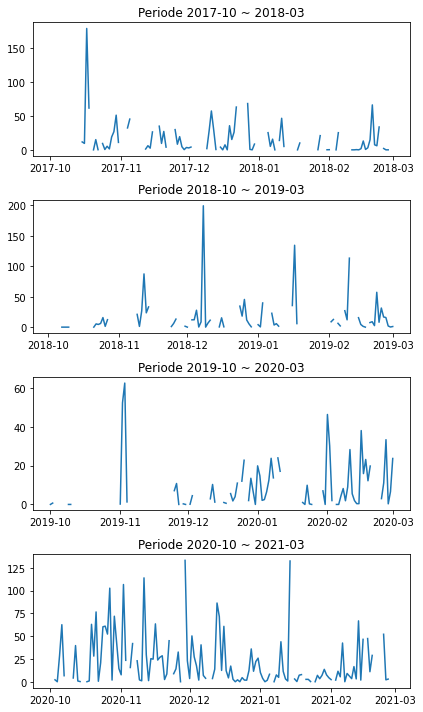

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,10))

axes[0].plot(df_periode1['curah_hujan'])
axes[0].set_title('Periode 2017-10 ~ 2018-03')

axes[1].plot(df_periode2['curah_hujan'])
axes[1].set_title('Periode 2018-10 ~ 2019-03')

axes[2].plot(df_periode3['curah_hujan'])
axes[2].set_title('Periode 2019-10 ~ 2020-03')

axes[3].plot(df_periode4['curah_hujan'])
axes[3].set_title('Periode 2020-10 ~ 2021-03')

plt.tight_layout()

## 2.3 Boxplot 'curah_hujan' per periode

In [9]:
# Note : Urutan bulan boxplots dibawah dimulai dari yang terkecil ke terbesar. Keep that in mind when analyzing.
# Mau diubah ke 10-11-12-01-02-03 tapi masih belum bisa

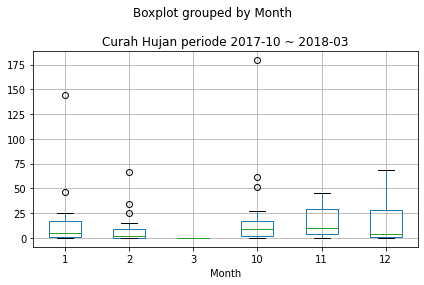

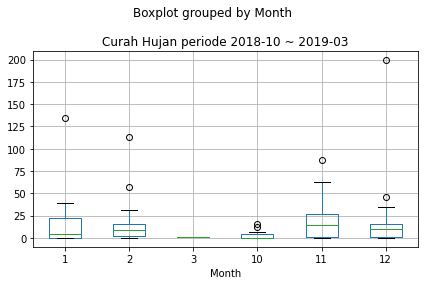

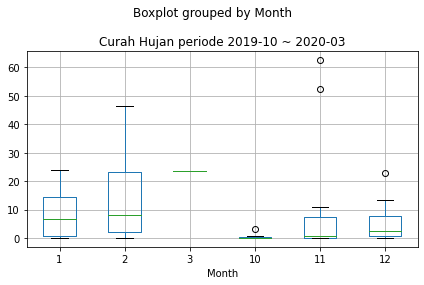

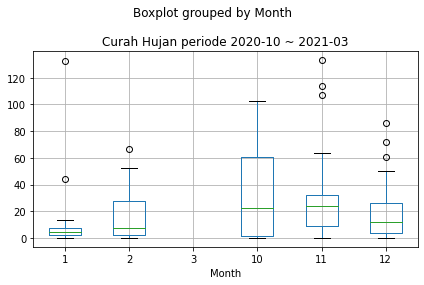

In [10]:
df_periode1.boxplot(column=['curah_hujan'], by='Month', figsize=(6, 4))
plt.title('Curah Hujan periode 2017-10 ~ 2018-03')
plt.tight_layout()

df_periode2.boxplot(column=['curah_hujan'], by='Month', figsize=(6, 4))
plt.title('Curah Hujan periode 2018-10 ~ 2019-03')
plt.tight_layout()

df_periode3.boxplot(column=['curah_hujan'], by='Month', figsize=(6, 4))
plt.title('Curah Hujan periode 2019-10 ~ 2020-03')
plt.tight_layout()

df_periode4.boxplot(column=['curah_hujan'], by='Month', figsize=(6, 4))
plt.title('Curah Hujan periode 2020-10 ~ 2021-03')
plt.tight_layout()


## 2.4 Pairplot all features vs 'curah_hujan'

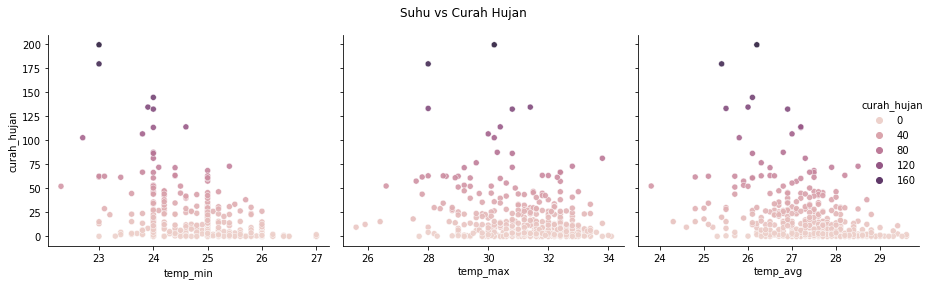

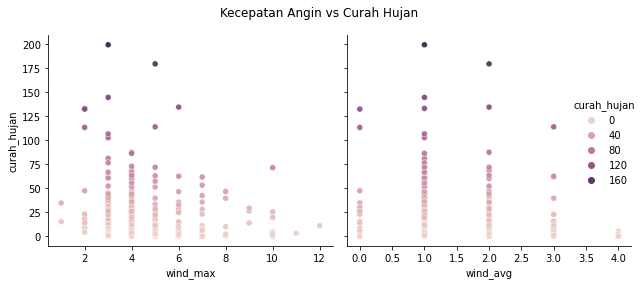

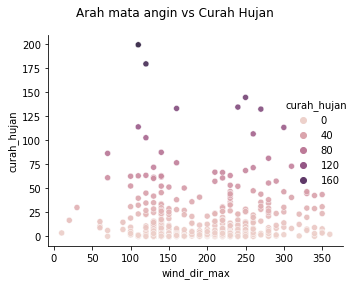

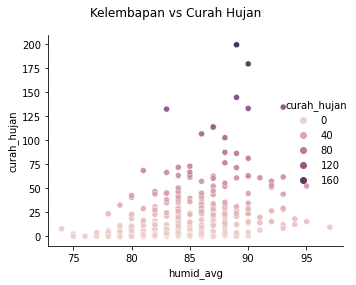

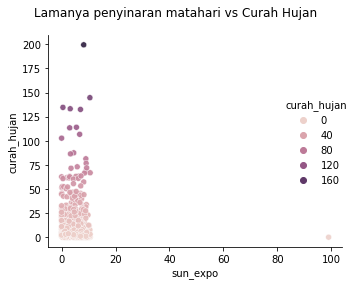

In [11]:
def pp(judul, *args):
    sns.pairplot(data=df, x_vars=args, y_vars=['curah_hujan'], height=4, aspect=1, kind='scatter', plot_kws={'alpha':0.9}, diag_kind = None, hue='curah_hujan')
    plt.suptitle(judul)
    plt.tight_layout()
    plt.show()
    
pp('Suhu vs Curah Hujan', 'temp_min', 'temp_max', 'temp_avg', )
pp('Kecepatan Angin vs Curah Hujan', 'wind_max', 'wind_avg')
pp('Arah mata angin vs Curah Hujan', 'wind_dir_max')
pp('Kelembapan vs Curah Hujan', 'humid_avg')
pp('Lamanya penyinaran matahari vs Curah Hujan', 'sun_expo')

## 2.5 Person Correlation Matrix

<ipython-input-12-9a80950b0ddc>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.reindex(columns=column_names).corr(), dtype=np.bool)


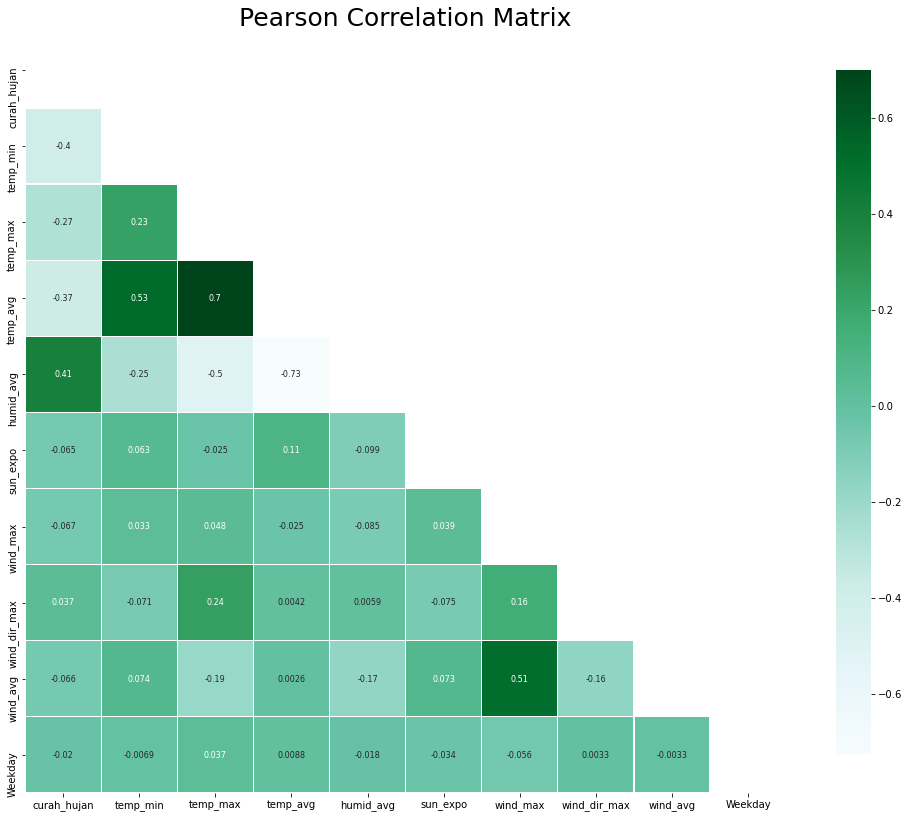

In [12]:
column_names = ['curah_hujan', 'temp_min', 'temp_max', 'temp_avg', 'humid_avg',
                'sun_expo', 'wind_max', 'wind_dir_max', 'wind_avg', 'wind_dir', 'Year',
                'Month', 'Weekday']



mask = np.zeros_like(df.reindex(columns=column_names).corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 14))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df.reindex(columns=column_names).corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

# sources, thx to : https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices

## 2.6 3D Scatter plot

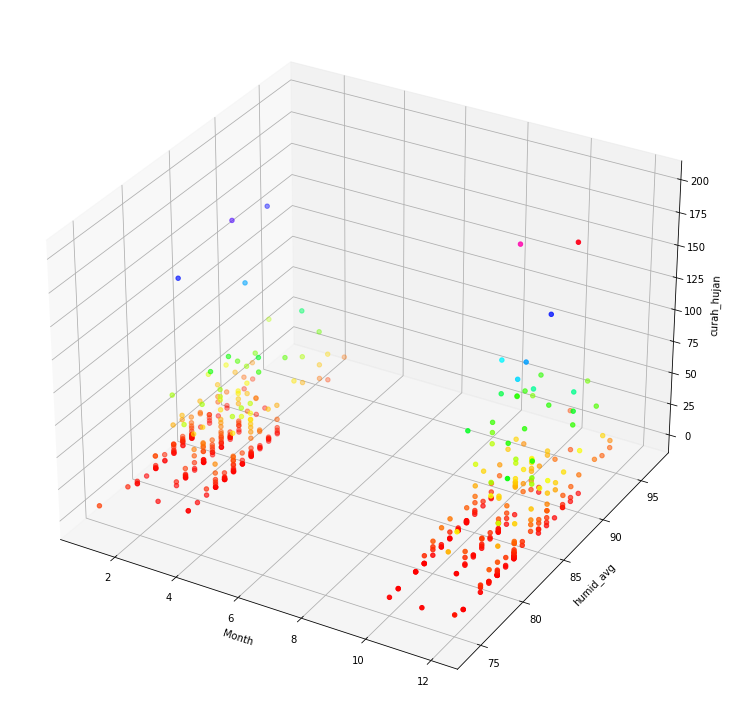

In [13]:
# Dari heatmap diatas kita ambil variabel dengan korelasi paling tinggi dengan curah_hujan yaitu humid_avg lalu kita buat scatter3D plotnya

fig = plt.figure(figsize=(13, 13))
ax = plt.axes(projection="3d")

z_points = df['curah_hujan']
x_points = df['Month']
y_points = df['humid_avg']
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

ax.set_xlabel('Month')
ax.set_ylabel('humid_avg')
ax.set_zlabel('curah_hujan')

plt.show()

## 2.7 Missing Data

<AxesSubplot:>

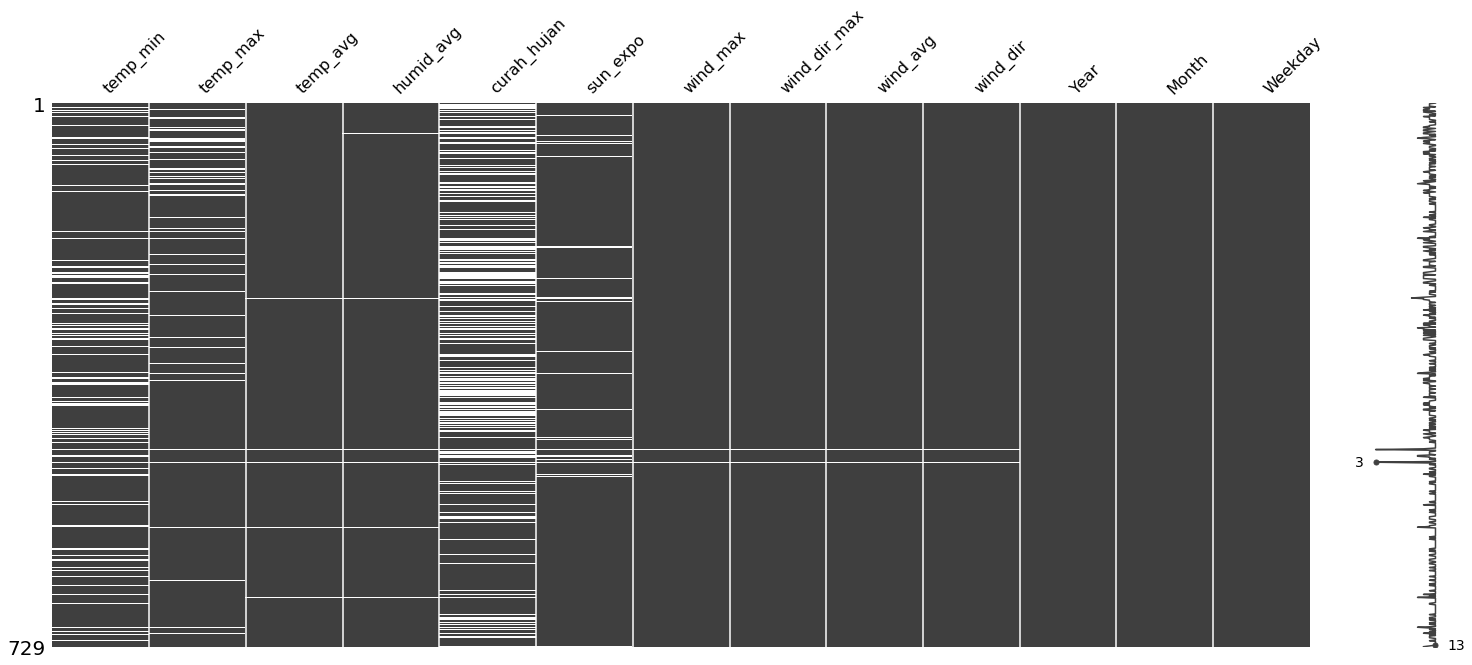

In [14]:
mno.matrix(df)

Di BMKG, tidak ada hujan sama sekali di interpretasi sebagai no-value. Dengan pengetahuan ini kita dapat mengubah missing_value di 'curah_hujan' menjadi value = 0

# 3. Data Preparation (data cleaning)

In [15]:
#missing data

df.isnull().sum()

temp_min        109
temp_max         60
temp_avg          5
humid_avg         6
curah_hujan     236
sun_expo         35
wind_max          2
wind_dir_max      2
wind_avg          2
wind_dir          2
Year              0
Month             0
Weekday           0
dtype: int64

In [16]:
# mengganti missing values di kolom curah_hujan dengan 0
df_filtered_1 = df.replace({'curah_hujan': np.nan},0)
df_filtered_1.head()

,temp_min,temp_max,temp_avg,humid_avg,curah_hujan,sun_expo,wind_max,wind_dir_max,wind_avg,wind_dir,Year,Month,Weekday
datetime,,,,,,,,,,,,,
2017-10-01,25.0,29.3,27.4,82.0,0.6,7.0,6.0,120.0,4.0,SE,2017,10,6
2017-10-02,25.0,29.2,27.0,81.0,0.0,7.3,4.0,130.0,3.0,SE,2017,10,0
2017-10-03,26.0,27.2,26.0,87.0,0.0,8.3,4.0,120.0,2.0,SE,2017,10,1
2017-10-04,25.0,29.2,26.6,85.0,0.0,6.0,7.0,120.0,4.0,SE,2017,10,2
2017-10-05,24.0,29.4,26.8,88.0,0.0,5.3,6.0,120.0,4.0,E,2017,10,3


In [17]:
# menghapus missing values perbaris di kolom curah hujan
df_filtered_2 = df.dropna(subset=['curah_hujan'])
df_filtered_2.head()

,temp_min,temp_max,temp_avg,humid_avg,curah_hujan,sun_expo,wind_max,wind_dir_max,wind_avg,wind_dir,Year,Month,Weekday
datetime,,,,,,,,,,,,,
2017-10-01,25.0,29.3,27.4,82.0,0.6,7.0,6.0,120.0,4.0,SE,2017,10,6
2017-10-06,26.0,29.8,28.0,84.0,1.5,7.0,7.0,100.0,4.0,SE,2017,10,4
2017-10-09,25.0,NaN,27.4,85.0,1.8,7.3,6.0,120.0,3.0,SE,2017,10,0
2017-10-12,26.0,30.2,27.9,88.0,12.0,0.5,5.0,130.0,2.0,E,2017,10,3
2017-10-15,25.0,30.0,27.4,84.0,11.7,8.5,4.0,140.0,2.0,SE,2017,10,6


In [18]:
df_filtered_1.isnull().sum()

temp_min        109
temp_max         60
temp_avg          5
humid_avg         6
curah_hujan       0
sun_expo         35
wind_max          2
wind_dir_max      2
wind_avg          2
wind_dir          2
Year              0
Month             0
Weekday           0
dtype: int64

In [19]:
df_filtered_2.isnull().sum()

temp_min        56
temp_max        36
temp_avg         2
humid_avg        2
curah_hujan      0
sun_expo        17
wind_max         0
wind_dir_max     0
wind_avg         0
wind_dir         0
Year             0
Month            0
Weekday          0
dtype: int64

In [20]:
# Data check

print(f"original df shape :\t {df.shape}")
print(f"df_filtered_1 shape :\t {df_filtered_1.shape}")
print(f"df_filtered_2 shape :\t {df_filtered_2.shape}")

original df shape :	 (729, 13)
df_filtered_1 shape :	 (729, 13)
df_filtered_2 shape :	 (493, 13)


<AxesSubplot:>

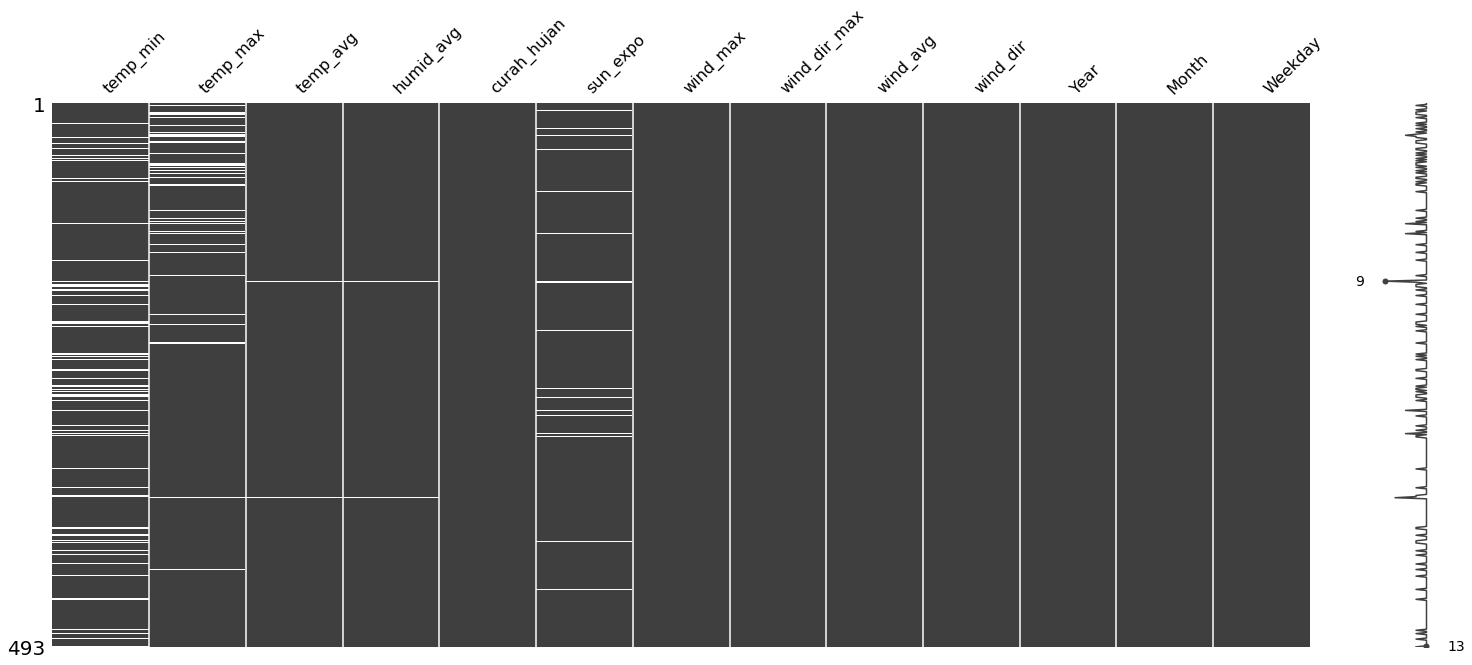

In [21]:
mno.matrix(df_filtered_2)

# 4. Before Modeling

In [22]:
# sementara drop all missing value
df_filtered_2 = df_filtered_2.dropna()
df_filtered_2.isnull().sum()

temp_min        0
temp_max        0
temp_avg        0
humid_avg       0
curah_hujan     0
sun_expo        0
wind_max        0
wind_dir_max    0
wind_avg        0
wind_dir        0
Year            0
Month           0
Weekday         0
dtype: int64

## 4.1 Splitting DataFrame into X and y

#### 4.1.1 splitting data into X and y with categorical data

In [23]:
# Disini kita menggunakan 5 fitur
X = df_filtered_2.drop(['curah_hujan', 'wind_dir_max', 'Weekday'], axis=1)
y = df_filtered_2.loc[:, 'curah_hujan']

print(X.columns)

# Karena banyak tools yang mewajibkan kita menggunakan numpy array, maka kita ubah X dan y menjadi array
X_array = X.to_numpy()
y_array = y.to_numpy()

# Karena feature scaling expect 2-d array, kita perlu mengubah y menjadi 2-d dulu
y_array = y_array.reshape(len(y), 1)

Index(['temp_min', 'temp_max', 'temp_avg', 'humid_avg', 'sun_expo', 'wind_max',
       'wind_avg', 'wind_dir', 'Year', 'Month'],
      dtype='object')


In [24]:
# Show first 2 rows
print(X_array[:2, :])
print(y_array[:2, :])

[[25.0 29.3 27.4 82.0 7.0 6.0 4.0 'SE' 2017 10]
 [26.0 29.8 28.0 84.0 7.0 7.0 4.0 'SE' 2017 10]]
[[0.6]
 [1.5]]


#### 4.1.2 splitting data into X and y without categorical data

## 4.2 OneHotEncoding (if using categorical)

In [25]:
# We want to encode 'wind_dir', 'Year', 'Month'
# Because those column is a pure Categorical, not ordinal data (like year 2019 is more blablabla than 2020)
# in order to avoid ordinal interpretation we use OneHotEncoder

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# encode wind_dir
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-3])], remainder='passthrough')
X_array = ct.fit_transform(X_array) # remember in order to train ml model, it needs to be a numpy array

In [27]:
# encode year

year_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-2])], remainder='passthrough')
X_array = year_ct.fit_transform(X_array)

In [28]:
# encode month

month_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1])], remainder='passthrough')
X_array = month_ct.fit_transform(X_array)

In [29]:
# for fixing
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

X_array = np.asarray(X_array).astype('float32')

In [30]:
# Show first 1 rows
print(X_array[:1, :])
print(y_array[:1, :])

[[ 0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   0.   0.  25.  29.3 27.4 82.   7.   6.   4. ]]
[[0.6]]


## 4.3 Train-Test split

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, train_size = 0.8, random_state = 1)

## 4.4 Feature Scaling

#### 4.4.1 feature scaling dengan data categorical

Karena kita hanya ingin men-scale nilai numerical, kita transform dataset dengan indexing [:, 18:]

In [32]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler() # We cannot use same scaler for both X and y
X_train[:, 18:] = sc_X.fit_transform(X_train[:, 18:])
y_train = sc_y.fit_transform(y_train).ravel()

# We also need to transform test set
X_test[:, 18:] = sc_X.transform(X_test[:, 18:])
y_test = sc_y.transform(y_test)

# Kalau mau ngeluarin real-result, jangan lupa gunakan inverse_transform

In [33]:
X_train.shape

(312, 26)

#### 4.4.2 feature scaling tanpa data categorical

In [34]:
X_train.shape

(312, 26)

# 5. Modeling

## 5.1 Regresi Linear (Single Variable)

Untuk melakukan regresi linear, kita perlu mengetahui independent variable mana yang paling berpengaruh ke dependent variabel (curah_hujan)

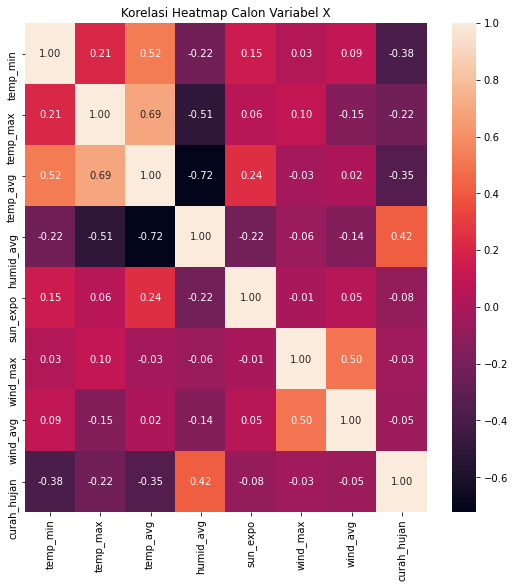

In [35]:
plt.figure(figsize=(9, 9))
sns.heatmap(pd.concat([X, y], axis=1).corr() ,annot=True ,fmt=".2f").set_title("Korelasi Heatmap Calon Variabel X")
plt.show()

Dari hasil visualisasi diatas, dapat diketahui humid_avg memiliki korelasi yang tinggi terhadap kolom curah_hujan / variabel dependent sehingga kita mengambil fitur/kolom humid_avg untuk di training

    Independent variabel(X) adalah humid_avg.
    Dependent variabel(y) adalah curah_hujan.



In [36]:
X_train[:1, :]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.28867516, -0.03242825,
        -0.10821071, -0.94994885,  0.02948356, -0.3568618 ,  4.0519433 ,
         0.753395  ]], dtype=float32)

Jika kita perhatikan columns, berikut adalah urutannya:
'Month', 'Year', 'wind_dir', temp_min', 'temp_max', 'temp_avg', 'humid_avg', 'sun_expo', 'wind_max', 'wind_avg'

Oleh karena itu kita gunakan [:, -4]

In [37]:
# Kita ambil humid_avg saja dari train_test data, oleh karena itu kita menggunakan X_train[:, -4]

from sklearn import linear_model

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train[:, -4].reshape(-1, 1), y_train)

y_pred = linear_reg.predict(X_test[:, -4].reshape(-1, 1))

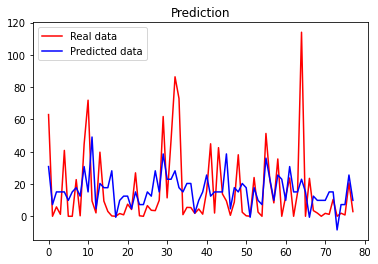

In [38]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [39]:
# Model Evaluation

mse_linear_reg = mean_squared_error(y_test, y_pred)
mae_linear_reg = mean_absolute_error(y_test, y_pred)
r2_linear_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_linear_reg})")
print(f"Mean Square Error: {mse_linear_reg}")
print(f"R2-score: {r2_linear_reg}")

Mean Absolute Error: 0.6302548547647816)
Mean Square Error: 0.8050114562064533
R2-score: 0.18011865979281672


## 5.2 Linear Regression (Multiple Variables)

In [40]:
X_train[:1, [-7,-4]]

array([[-0.03242825,  0.02948356]], dtype=float32)

In [41]:
# Kita ambil humid_avg saja dari train_test data, oleh karena itu kita menggunakan X_train[:, -4]

from sklearn import linear_model

multi_reg = linear_model.LinearRegression()
multi_reg.fit(X_train[:, [-7,-4]], y_train)

y_pred = multi_reg.predict(X_test[:, [-7,-4]])

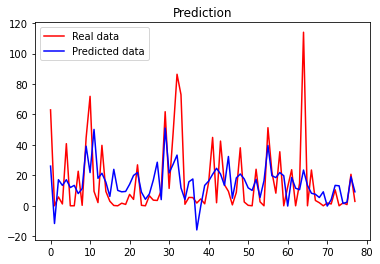

In [42]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [43]:
# Model Evaluation

mse_multi_reg = mean_squared_error(y_test, y_pred)
mae_multi_reg = mean_absolute_error(y_test, y_pred)
r2_multi_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_multi_reg})")
print(f"Mean Square Error: {mse_multi_reg}")
print(f"R2-score: {r2_multi_reg}")

Mean Absolute Error: 0.5951334023037145)
Mean Square Error: 0.737122118109041
R2-score: 0.24926202548773935


## 5.3 Decision Tree

In [44]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

y_pred = dt_reg.predict(X_test)

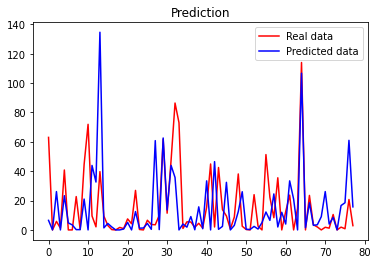

In [45]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [46]:
# Model Evaluation

mse_dt_reg = mean_squared_error(y_test, y_pred)
mae_dt_reg = mean_absolute_error(y_test, y_pred)
r2_dt_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_dt_reg}")
print(f"Mean Square Error: {mse_dt_reg}")
print(f"R2-score: {r2_dt_reg}")

Mean Absolute Error: 0.6725174808502268
Mean Square Error: 1.1517730883106319
R2-score: -0.17304822928694774


## 5.4 Random Forest Regression

In [47]:
# Import Library Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

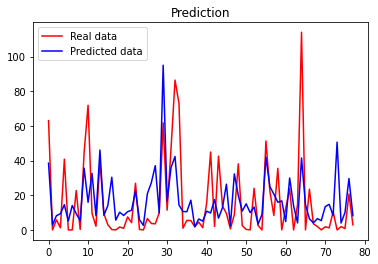

In [48]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [49]:
# Model Evaluation

mse_rf_reg = mean_squared_error(y_test, y_pred)
mae_rf_reg = mean_absolute_error(y_test, y_pred)
r2_rf_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_rf_reg}")
print(f"Mean Square Error: {mse_rf_reg}")
print(f"R2-score: {r2_rf_reg}")

Mean Absolute Error: 0.5875509334046312
Mean Square Error: 0.7193208093333798
R2-score: 0.2673921536789684


## 5.5 ANN

Karena contoh yang digunakan di module merupakan contoh ANN classification, saya gunakan referensi dari luar

source : https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression

In [50]:
print(X_train[:1])
print(X_train.shape)

[[ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          1.
   0.          0.          0.          0.          0.          0.
  -0.28867516 -0.03242825 -0.10821071 -0.94994885  0.02948356 -0.3568618
   4.0519433   0.753395  ]]
(312, 26)


In [51]:
print(f"input dim = {X_train.shape[1:]}")

input dim = (26,)


In [72]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(6, activation = 'relu', input_dim = 26))

# Adding the second hidden layer
model.add(Dense(units = 6, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 6, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 32, epochs = 200)

y_pred = model.predict(X_test)

Epoch 1/200
10/10 [==============================] - 1s 3ms/step - loss: 1.3015
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1902
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1103
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0557
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 1.0131
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 0.9807
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 0.9532
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 0.9297
Epoch 9/200
10/10 [==============================] - 0s 4ms/step - loss: 0.9125
Epoch 10/200
10/10 [==============================] - 0s 4ms/step - loss: 0.8919
Epoch 11/200
10/10 [==============================] - 0s 3ms/step - loss: 0.8760
Epoch 12/200
10/10 [==============================] - 0s 4ms/step - loss: 0.8620
Epoch 13/200
10/10 [=================

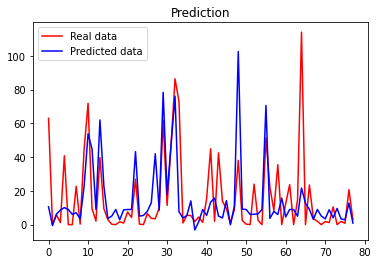

In [73]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [74]:
# Model Evaluation

mse_ann_reg = mean_squared_error(y_test, y_pred)
mae_ann_reg = mean_absolute_error(y_test, y_pred)
r2_ann_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_ann_reg}")
print(f"Mean Square Error: {mse_ann_reg}")
print(f"R2-score: {r2_ann_reg}")

Mean Absolute Error: 0.5491090746511533
Mean Square Error: 0.7772694885605537
R2-score: 0.2083730671532894


## 6. Model evaluation and hyperparameter tuning

## 6.1 Mean Absolute Error

In [75]:
models = pd.DataFrame({'Model': ['Linear Regression', 'Multiple Linear Regression', 'Decision Tree', 'Random Forest Regression', 'ANN'],
                       'Score': [mae_linear_reg, mae_multi_reg, mae_dt_reg, mae_rf_reg, mae_ann_reg]})

models.sort_values(by = 'Score', ascending = True, ignore_index = True)


,Model,Score
0,ANN,0.549109
1,Random Forest Regression,0.587551
2,Multiple Linear Regression,0.595133
3,Linear Regression,0.630255
4,Decision Tree,0.672517


Note : Lower MAE are better.

## 6.2 R2

In [76]:
models = pd.DataFrame({'Model': ['Linear Regression', 'Multiple Linear Regression', 'Decision Tree', 'Random Forest Regression', 'ANN'],
                       'Score': [r2_linear_reg, r2_multi_reg, r2_dt_reg, r2_rf_reg, r2_ann_reg]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)


,Model,Score
0,Random Forest Regression,0.267392
1,Multiple Linear Regression,0.249262
2,ANN,0.208373
3,Linear Regression,0.180119
4,Decision Tree,-0.173048


Note : Higher R2 score are better.

## 6.2 K-fold cross validation

It is important to not get too carried away with models with impressive training accuracy as what we should focus on instead is the model's ability to predict out-of-samples data, in other words, data our model has not seen before.

This is where k-fold cross validation comes in. K-fold cross validation is a technique whereby a subset of our training set is kept aside and will act as holdout set for testing purposes. Here is a great [video](https://www.youtube.com/watch?v=fSytzGwwBVw) explaining the concept in more detail. 